# Projeto Final – Pipeline Completo de Ciência de Dados com Dados Reais

Autores: Jonathan Gonçalves Possa e Matheus Rossi Carvalho  

Este notebook implementa um pipeline completo de Ciência de Dados, desde a contextualização do problema até a comunicação dos insights finais, utilizando **dados reais de ações brasileiras negociadas na B3** (via API `yfinance`).  

O projeto segue as etapas:

1. Escolha e contextualização do dataset  
2. Coleta e carregamento de dados  
3. Limpeza e preparação  
4. Análise exploratória (EDA)  
5. Modelagem  
6. Visualização e dashboard  
7. Storytelling e comunicação  

In [ ]:
# =============================
# 0. Preparacao do ambiente
# =============================

# Bibliotecas principais
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Modelagem
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
)
from sklearn.linear_model import LogisticRegression

# Configuracoes de exibicao
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")
sns.set(style="whitegrid")

print("Ambiente pronto.")


Ambiente pronto.


## Etapas do Projeto (Pipeline Completo)

### 1. Escolha e contextualização do dataset

Nesta etapa é definido o tema do projeto, a fonte dos dados e a relevância social ou econômica do problema.

- **Tema:** comportamento de ações brasileiras negociadas na B3.  
- **Fonte:** API pública do Yahoo Finance, acessada via biblioteca `yfinance`.  
- **Ativos analisados (exemplo):**
  - `PETR4.SA` – Petrobras PN  
  - `VALE3.SA` – Vale ON  
  - `BOVA11.SA` – ETF que replica o Ibovespa  

- **Relevância econômica:**  
  - Apoio à tomada de decisão de investimento.  
  - Avaliação de risco e volatilidade.  
  - Entendimento de correlações entre ativos relevantes para a economia brasileira.

**Perguntas orientadoras:**

1. Como se comportaram o preço ajustado e o retorno diário de PETR4, VALE3 e BOVA11 ao longo do período analisado?  
2. Os retornos desses ativos apresentam correlação relevante entre si?  
3. Um modelo simples consegue prever se o retorno de BOVA11 será positivo no próximo pregão com base nos retornos atuais dos ativos?  


### 2. Coleta e carregamento de dados

Nesta etapa os dados são obtidos a partir de uma fonte pública, utilizando **API**.  
No contexto deste projeto:

- Utiliza-se a biblioteca `yfinance` para acessar a API do Yahoo Finance.  
- O período de análise inicia em `2018-01-01` e segue até a data mais recente disponível.  
- São coletados preços ajustados de fechamento (Adj Close) para os ativos selecionados.  
- Os dados são organizados em um `DataFrame` chamado `df_raw`.  


In [ ]:
# =============================
# 2 Coleta e carregamento de dados
# =============================

# Instalacao da biblioteca yfinance (necessario rodar uma vez no Colab)
# Descomente a linha abaixo quando for executar pela primeira vez no Google Colab.
# !pip install yfinance

import yfinance as yf

# Definicao de ativos e periodo
ativos = ["PETR4.SA", "VALE3.SA", "BOVA11.SA"]
data_inicio = "2018-01-01"
data_fim = None  # None = ate a data atual disponivel na API

print("Ativos analisados:", ativos)
print("Periodo:", data_inicio, "ate", "data mais recente disponivel")

# Download dos dados de preco com auto_adjust=False para garantir a coluna 'Adj Close'
dados = yf.download(ativos, start=data_inicio, end=data_fim, auto_adjust=False)

# Organizacao do DataFrame base
# Trabalhando inicialmente com o preco ajustado (Adj Close)
df_raw = dados["Adj Close"].reset_index().rename(columns={"Date": "data"})

print("\nDimensoes de df_raw:", df_raw.shape)
display(df_raw.head())


Ativos analisados: ['PETR4.SA', 'VALE3.SA', 'BOVA11.SA']
Periodo: 2018-01-01 ate data mais recente disponivel


[*********************100%***********************]  3 of 3 completed


Dimensoes de df_raw: (1959, 4)


Ticker,data,BOVA11.SA,PETR4.SA,VALE3.SA
0,2018-01-02,75.1000,4.5486,22.8037
1,2018-01-03,75.3000,4.5898,22.6671
2,2018-01-04,76.0000,4.5981,22.7600
3,2018-01-05,76.4400,4.6256,23.1153
4,2018-01-08,76.7600,4.6805,23.6291


### 3. Limpeza e preparação

Nesta etapa o foco é garantir a qualidade da base e criar variáveis derivadas importantes para as próximas análises.

**Ações adotadas:**

- Conversão da coluna `data` para o tipo datetime.  
- Remoção de linhas com data nula.  
- Remoção de linhas em que todos os preços estejam ausentes (pregão inexistente).  
- Criação das colunas de **retorno diário** para cada ativo (`*_ret`).  
- Criação da variável-alvo `target_up`, que indica se o retorno de BOVA11 no próximo pregão será positivo.  

O resultado é um `DataFrame` limpo e enriquecido chamado `df`, pronto para a EDA e a modelagem.


In [ ]:
# =============================
# 3. Limpeza e preparacao
# =============================

df = df_raw.copy()

# Conversao da coluna de data para datetime
df["data"] = pd.to_datetime(df["data"], errors="coerce")

# Remocao de linhas com data nula
df = df.dropna(subset=["data"])

# Remover linhas em que todos os ativos estao nulos
preco_cols = [c for c in df.columns if c != "data"]
df = df.dropna(how="all", subset=preco_cols)

print("Dimensoes apos limpeza basica:", df.shape)

# Criacao de colunas de retorno diario para cada ativo
for ativo in ativos:
    if ativo in df.columns:
        df[f"{ativo}_ret"] = df[ativo].pct_change()

# Remover primeira linha com retornos nulos
ret_cols = [c for c in df.columns if c.endswith("_ret")]
df = df.dropna(subset=ret_cols)

print("Dimensoes apos criacao dos retornos:", df.shape)
display(df.head())

# Criacao da variavel-alvo: retorno futuro de BOVA11 positivo (1) ou nao (0)
col_ret_bova = "BOVA11.SA_ret"
if col_ret_bova in df.columns:
    df["ret_bova_futuro"] = df[col_ret_bova].shift(-1)
    df = df.dropna(subset=["ret_bova_futuro"])
    df["target_up"] = (df["ret_bova_futuro"] > 0).astype(int)

print("\nAmostra com coluna alvo:")
display(df[["data", "BOVA11.SA", col_ret_bova, "ret_bova_futuro", "target_up"]].head())


Dimensoes apos limpeza basica: (1959, 4)
Dimensoes apos criacao dos retornos: (1958, 7)


/tmp/ipython-input-2230248607.py:22: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df[f"{ativo}_ret"] = df[ativo].pct_change()


Ticker,data,BOVA11.SA,PETR4.SA,VALE3.SA,PETR4.SA_ret,VALE3.SA_ret,BOVA11.SA_ret
1,2018-01-03,75.3000,4.5898,22.6671,0.0091,-0.0060,0.0027
2,2018-01-04,76.0000,4.5981,22.7600,0.0018,0.0041,0.0093
3,2018-01-05,76.4400,4.6256,23.1153,0.0060,0.0156,0.0058
4,2018-01-08,76.7600,4.6805,23.6291,0.0119,0.0222,0.0042
5,2018-01-09,76.1600,4.6805,23.5416,0.0000,-0.0037,-0.0078



Amostra com coluna alvo:


Ticker,data,BOVA11.SA,BOVA11.SA_ret,ret_bova_futuro,target_up
1,2018-01-03,75.3000,0.0027,0.0093,1
2,2018-01-04,76.0000,0.0093,0.0058,1
3,2018-01-05,76.4400,0.0058,0.0042,1
4,2018-01-08,76.7600,0.0042,-0.0078,0
5,2018-01-09,76.1600,-0.0078,-0.0074,0


### 4. Análise exploratória de dados (EDA)

Nesta etapa são exploradas estatísticas, correlações e padrões do conjunto de dados.

**Principais atividades:**

- Cálculo de estatísticas descritivas para as variáveis numéricas (preços e retornos).  
- Análise das distribuições dos retornos diários por meio de histogramas.  
- Avaliação da volatilidade ao longo do tempo via desvio padrão móvel (rolling std).  
- Cálculo e visualização da **matriz de correlação** entre os retornos dos ativos.  

Essa análise ajuda a entender o comportamento dos ativos e serve de base para os insights e para a modelagem.


Variaveis numericas: ['BOVA11.SA', 'PETR4.SA', 'VALE3.SA', 'PETR4.SA_ret', 'VALE3.SA_ret', 'BOVA11.SA_ret', 'ret_bova_futuro', 'target_up']


,count,mean,std,min,25%,50%,75%,max
Ticker,,,,,,,,
BOVA11.SA,"1,939.0000",106.9014,17.4132,61.1400,95.8800,107.7700,120.6200,154.8000
PETR4.SA,"1,957.0000",15.5078,10.1864,3.3445,7.2971,10.4022,26.6989,35.6628
VALE3.SA,"1,957.0000",47.6778,15.2106,19.9077,30.3870,52.9616,57.8629,76.8482
PETR4.SA_ret,"1,957.0000",0.0014,0.0265,-0.2970,-0.0104,0.0010,0.0138,0.2222
VALE3.SA_ret,"1,957.0000",0.0008,0.0226,-0.2456,-0.0108,0.0000,0.0115,0.2136
BOVA11.SA_ret,"1,957.0000",0.0005,0.0149,-0.1457,-0.0069,0.0005,0.0082,0.1340
ret_bova_futuro,"1,957.0000",0.0005,0.0149,-0.1457,-0.0069,0.0005,0.0082,0.1340
target_up,"1,957.0000",0.5192,0.4998,0.0000,0.0000,1.0000,1.0000,1.0000


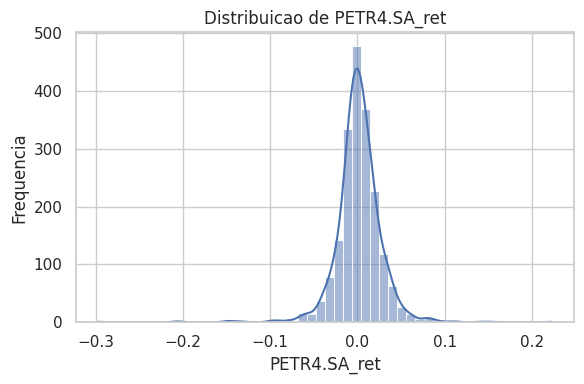

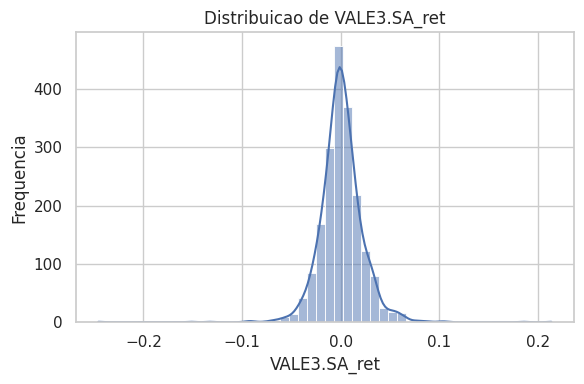

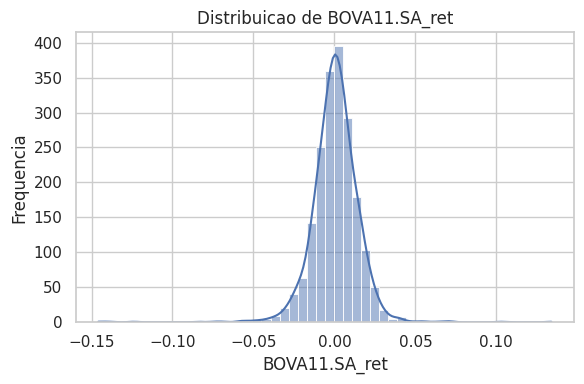

In [ ]:
# =============================
# 4.1. Estatisticas descritivas e distribuicoes
# =============================

num_cols = df.select_dtypes(include=np.number).columns.tolist()
print("Variaveis numericas:", num_cols)

display(df[num_cols].describe().T)

# Distribuicoes dos retornos diarios
ret_cols = [c for c in df.columns if c.endswith("_ret")]

for col in ret_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col].dropna(), kde=True, bins=50)
    plt.title(f"Distribuicao de {col}")
    plt.xlabel(col)
    plt.ylabel("Frequencia")
    plt.tight_layout()
    plt.show()


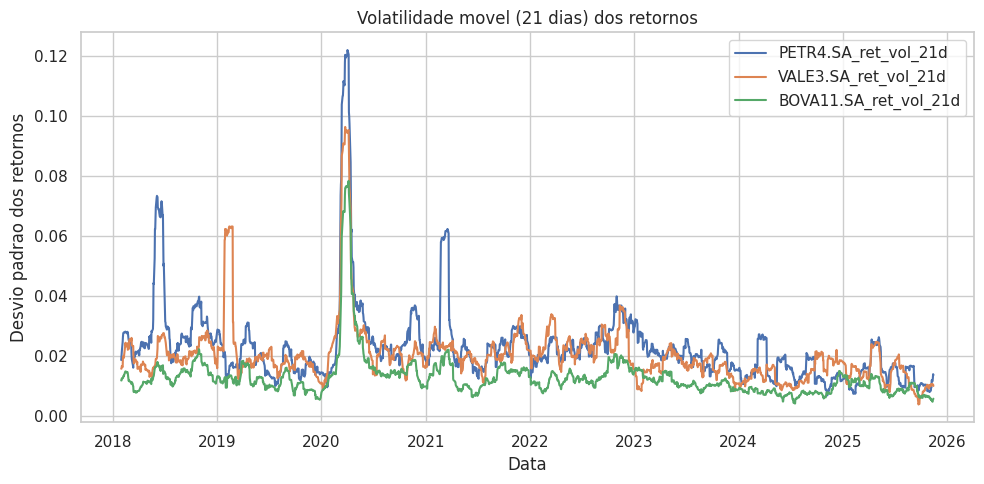

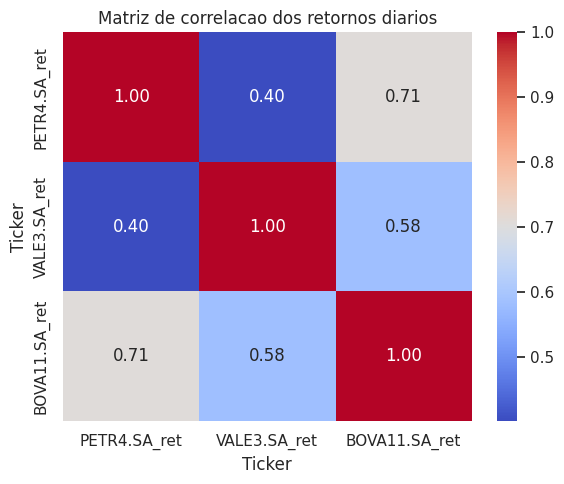

In [ ]:
# =============================
# 4.2. Volatilidade e correlacoes
# =============================

# Volatilidade movel (21 dias ~ 1 mes de pregacao)
window = 21
for col in ret_cols:
    df[f"{col}_vol_{window}d"] = df[col].rolling(window=window).std()

vol_cols = [c for c in df.columns if c.endswith(f"vol_{window}d")]

plt.figure(figsize=(10, 5))
for col in vol_cols:
    plt.plot(df["data"], df[col], label=col)
plt.title(f"Volatilidade movel ({window} dias) dos retornos")
plt.xlabel("Data")
plt.ylabel("Desvio padrao dos retornos")
plt.legend()
plt.tight_layout()
plt.show()

# Matriz de correlacao dos retornos
corr = df[ret_cols].corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de correlacao dos retornos diarios")
plt.tight_layout()
plt.show()


### 5. Modelagem

Nesta etapa é aplicada uma **técnica de modelagem simples** para responder a uma das perguntas do projeto.

**Configuração adotada:**

- Tipo de problema: **classificação binária**.  
- Variável-alvo (`target_up`):  
  - 1 se o retorno de BOVA11 no próximo pregão for positivo.  
  - 0 caso contrário.  
- Features: retornos diários atuais de PETR4, VALE3 e BOVA11 (`*_ret`).  
- Modelo utilizado: **Regressão Logística**, pela simplicidade e interpretabilidade.  

**Passos:**

1. Separar a base em treino e teste.  
2. Ajustar o modelo de Regressão Logística.  
3. Avaliar o desempenho usando acurácia, matriz de confusão e relatório de classificação.  


In [ ]:
# =============================
# 5. Modelagem - Regressao Logistica
# =============================

# Definicao das features e da variavel-alvo
feature_cols = [f"{ativo}_ret" for ativo in ativos if f"{ativo}_ret" in df.columns]
print("Features utilizadas no modelo:", feature_cols)

X = df[feature_cols].copy()
y = df["target_up"].copy()

# Separacao treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Modelo de classificacao
modelo = LogisticRegression(max_iter=1000)
modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)

# Avaliacao de desempenho
acc = accuracy_score(y_test, y_pred)
print(f"Acuracia no conjunto de teste: {acc:.4f}\n")

print("Relatorio de classificacao:")
print(classification_report(y_test, y_pred))

print("Matriz de confusao:")
print(confusion_matrix(y_test, y_pred))


Features utilizadas no modelo: ['PETR4.SA_ret', 'VALE3.SA_ret', 'BOVA11.SA_ret']
Acuracia no conjunto de teste: 0.5255

Relatorio de classificacao:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       186
           1       0.53      1.00      0.69       206

    accuracy                           0.53       392
   macro avg       0.26      0.50      0.34       392
weighted avg       0.28      0.53      0.36       392

Matriz de confusao:
[[  0 186]
 [  0 206]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### 6. Visualização e dashboard

Nesta etapa os resultados são consolidados em **visualizações** e em um **dashboard interativo**.

- Gráficos interativos são construídos com `plotly.express` para visualizar preços e retornos.  
- A base tratada (`df`) é exportada para um arquivo `.csv`, que será consumido pelo dashboard.  

Fluxo operacional:

1. Executar este notebook no Google Colab até a etapa 4.6.  
2. Baixar o arquivo `dados_tratados_para_dashboard.csv`.  
3. Colocar o `dados_tratados_para_dashboard.csv` na mesma pasta do `app.py` no seu computador.  
4. Executar `streamlit run app.py` para abrir o dashboard.  


In [ ]:
# =============================
# 6. Visualizacao e dashboard
# =============================

# 6.1. Graficos interativos principais

# Grafico de linha dos precos ajustados
fig_p = px.line(
    df,
    x="data",
    y=[a for a in ativos if a in df.columns],
    title="Precos ajustados ao longo do tempo - PETR4.SA, VALE3.SA, BOVA11.SA",
)
fig_p.show()

# Grafico de linha dos retornos diarios de BOVA11
if "BOVA11.SA_ret" in df.columns:
    fig_r = px.line(
        df,
        x="data",
        y="BOVA11.SA_ret",
        title="Retorno diario de BOVA11.SA",
    )
    fig_r.show()

# 6.2. Exportacao da base tratada para CSV

csv_nome = "dados_tratados_para_dashboard.csv"
df.to_csv(csv_nome, index=False)

print(f"Arquivo '{csv_nome}' salvo no ambiente do Colab.")
print("Na aba 'Arquivos' do Colab, localize o CSV, clique com o botao direito e faca o download.")
print("Em seguida, coloque o arquivo na mesma pasta do app.py no seu computador.")


Arquivo 'dados_tratados_para_dashboard.csv' salvo no ambiente do Colab.
Na aba 'Arquivos' do Colab, localize o CSV, clique com o botao direito e faca o download.
Em seguida, coloque o arquivo na mesma pasta do app.py no seu computador.


### 7. Storytelling e comunicação

Nesta etapa os resultados são traduzidos em uma narrativa clara, conectando dados, gráficos e implicações práticas.

A seguir são apresentados **três insights principais**, além de limitações e próximos passos.

---

#### Insight 1 – Comportamento de preços e retornos ao longo do tempo

**Pergunta:** como se comportaram os preços ajustados e os retornos diários de PETR4, VALE3 e BOVA11 no período analisado?  

**Evidências:**  

- Gráficos de linha dos preços ajustados mostram ciclos de alta e baixa, com períodos de maior volatilidade.  
- Histogramas de retornos diários indicam distribuição centrada em torno de zero, com caudas que refletem movimentos mais extremos.  

**Conclusão:**  

Os ativos apresentam comportamento típico de ações de grande liquidez, com retornos diários próximos de zero e episódios de forte variação. Isso reforça a importância de estratégias de gestão de risco e de um horizonte de investimento compatível com a volatilidade observada.  

**Limitações:**  

A análise é sensível ao período escolhido e não captura diretamente eventos pontuais (notícias, resultados, choques macroeconômicos).  

---

#### Insight 2 – Correlação entre retornos dos ativos analisados

**Pergunta:** existe correlação relevante entre os retornos diários de PETR4, VALE3 e BOVA11?  

**Evidências:**  

- A matriz de correlação dos retornos diários mostra correlações positivas entre os três ativos.  
- A relação entre BOVA11 e as ações individuais é particularmente forte, condizente com o papel do ETF como proxy do índice amplo.  

**Conclusão:**  

Os ativos tendem a se mover na mesma direção em boa parte do período analisado. Isso indica que uma carteira formada apenas por esses papéis pode ter **diversificação limitada**, mantendo alta exposição ao risco sistemático do mercado brasileiro.  

**Limitações:**  

- Correlação não implica causalidade.  
- A relação entre ativos pode mudar ao longo do tempo, e aqui foi avaliada de forma agregada.  

---

#### Insight 3 – Capacidade preditiva do modelo sobre o retorno de BOVA11

**Pergunta:** o modelo de Regressão Logística consegue prever, com qualidade razoável, se o retorno de BOVA11 será positivo no próximo pregão?  

**Evidências:**  

- Acurácia e métricas do relatório de classificação indicam desempenho melhor do que uma escolha totalmente aleatória, mas ainda limitado.  
- O modelo considera apenas retornos diários atuais dos três ativos, sem outras variáveis (volume, indicadores técnicos, fatores macro).  

**Conclusão:**  

O modelo funciona como um **baseline didático**, mostrando como estruturar um problema de classificação binária em finanças. Porém, ele não deve ser utilizado isoladamente para decisões de investimento, pois sua capacidade preditiva é restrita e pode variar com o período analisado.  

**Limitações:**  

- Poucas features utilizadas.  
- Ausência de validação mais robusta (como validação cruzada ou análise por janelas temporais).  

---

#### Limitações gerais do projeto

- Uso de uma única fonte de dados (Yahoo Finance).  
- Foco em poucos ativos e em um período específico, o que reduz a generalização.  
- Modelo simples, sem exploração de arquiteturas mais complexas ou tuning de hiperparâmetros.  

#### Próximos passos sugeridos

- Incluir novas variáveis (volume, indicadores técnicos, fatores macroeconômicos).  
- Testar modelos mais robustos (árvores de decisão, random forest, gradient boosting).  
- Realizar análises por subperíodos para investigar mudanças de regime de mercado.  
- Automatizar a atualização do dataset e do dashboard para uso contínuo.  
